In [1]:
import numpy as np
import pandas as pd
#from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib import gridspec
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import scipy
#from scipy import signal
#from scipy import ndimage
#from scipy.interpolate import interp1d
import IPython.display as ipd
from IPython.display import Image, Audio

import librosa

path_img = '../img/9.musically_informed_audio_decomposition/'
path_data = '../data_FMP/'

from utils.plot_tools import *

# Nonnegative Matrix Factorization (NMF)

- **NMF(Nonnegative Matrix Factorization)**(NMF)는 음수가 아닌 항목의 행렬 $V$를 역시 음수가 아닌 항목만 있는 두 개의 행렬 $W$ 및 $H$로 분해하는 기술이다.

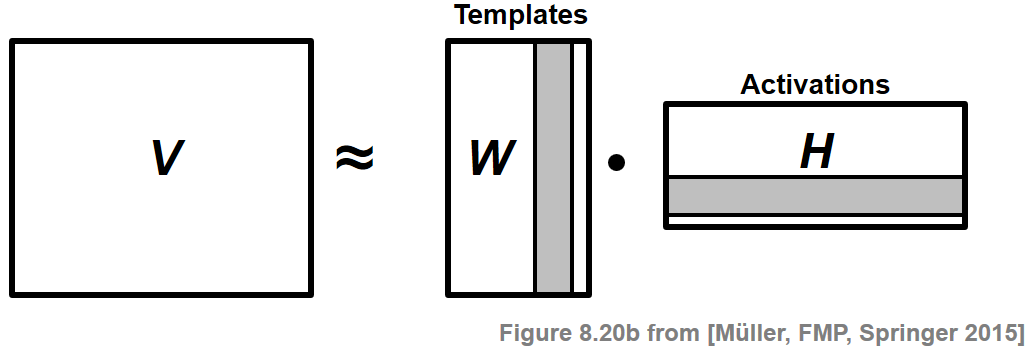

In [2]:
Image(path_img+"FMP_C8_F20b.png", width="400px")

- 일반적으로 행렬 $W$ 및 $H$는 원래 행렬 $V$보다 훨씬 낮은 rank를 가져야 한다. $V$의 열은 데이터 벡터로 간주된다. 기본 가정은 이러한 벡터가 상대적으로 적은 수의 **템플릿**(template) 벡터의 가중 중첩으로 표현될 수 있다는 것이다. $W$의 열은 이러한 템플릿에 해당한다. 또한 **활성화**(**activations**)라고 하는 $H$의 행은 이러한 템플릿이 $V$에서 발생하는 위치를 나타낸다.
- 음수가 아닌 제약 조건은 종종 계수의 의미 있는 해석을 허용하는 분해로 이어진다. 그러나 대부분의 경우 결과로 발생하는 분해 문제는 정확한 해가 없기 때문에 적절한 수치적 근사치를 찾기 위한 최적화 절차가 필요하다.
- 다음에서는 음악 도메인에서 인수분해 예제를 제공한다.

## Example: Spectrogam Factorization 

- NMF의 예시로, 이 기술을 사용하여 음악 녹음의 스펙트로그램을 음악적으로 의미 있는 구성 요소로 분해하는 방법을 본다.
- Frédéric Chopin의 Prélude Op.28, No.4를 예로 보자. 다음 그림은 연주의 오디오 녹음과 동기화된 악보의 피아노 롤 표현과 악보를 보여준다. 설명을 위해 음표 번호 $p=71$와 관련된 모든 정보는 빨간색 직사각형 프레임으로 강조 표시되어 있다.

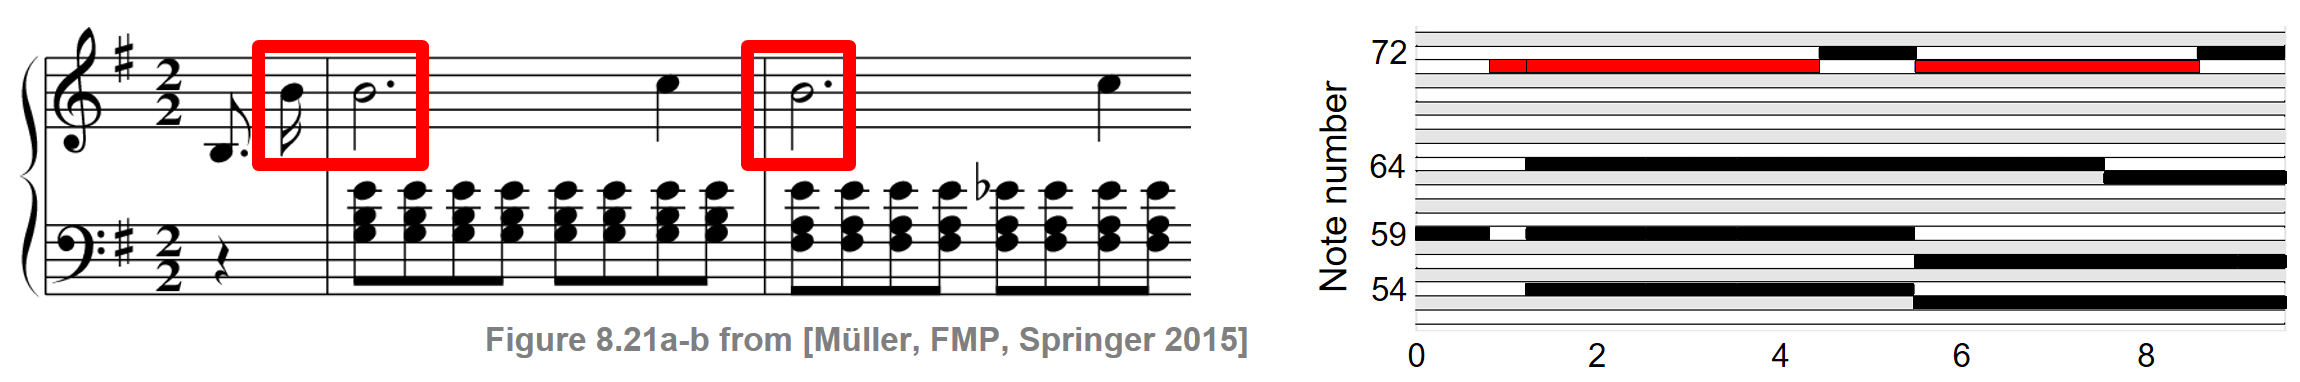

In [4]:
Image(path_img+"FMP_C8_F21a-b.png", width="600px")

- 원본 데이터 행렬 $V$는 스펙트럼 벡터의 시퀀스인 크기 STFT를 사용한다. NMF를 사용하면 이 행렬을 두 개의 비음수 행렬 $W$ 및 $H$의 곱으로 분해할 수 있다.
- 이상적인 경우 첫 번째 행렬 $W$는 음악에서 발생하는 음표 피치의 스펙트럼 패턴을 나타내고 두 번째 행렬 $H$는 오디오 녹음에서 이러한 스펙트럼 패턴이 활성화되는 시간 위치를 나타낸다. 다음 그림은 Chopin 예제에 대한 그러한 분해를 보여준다.

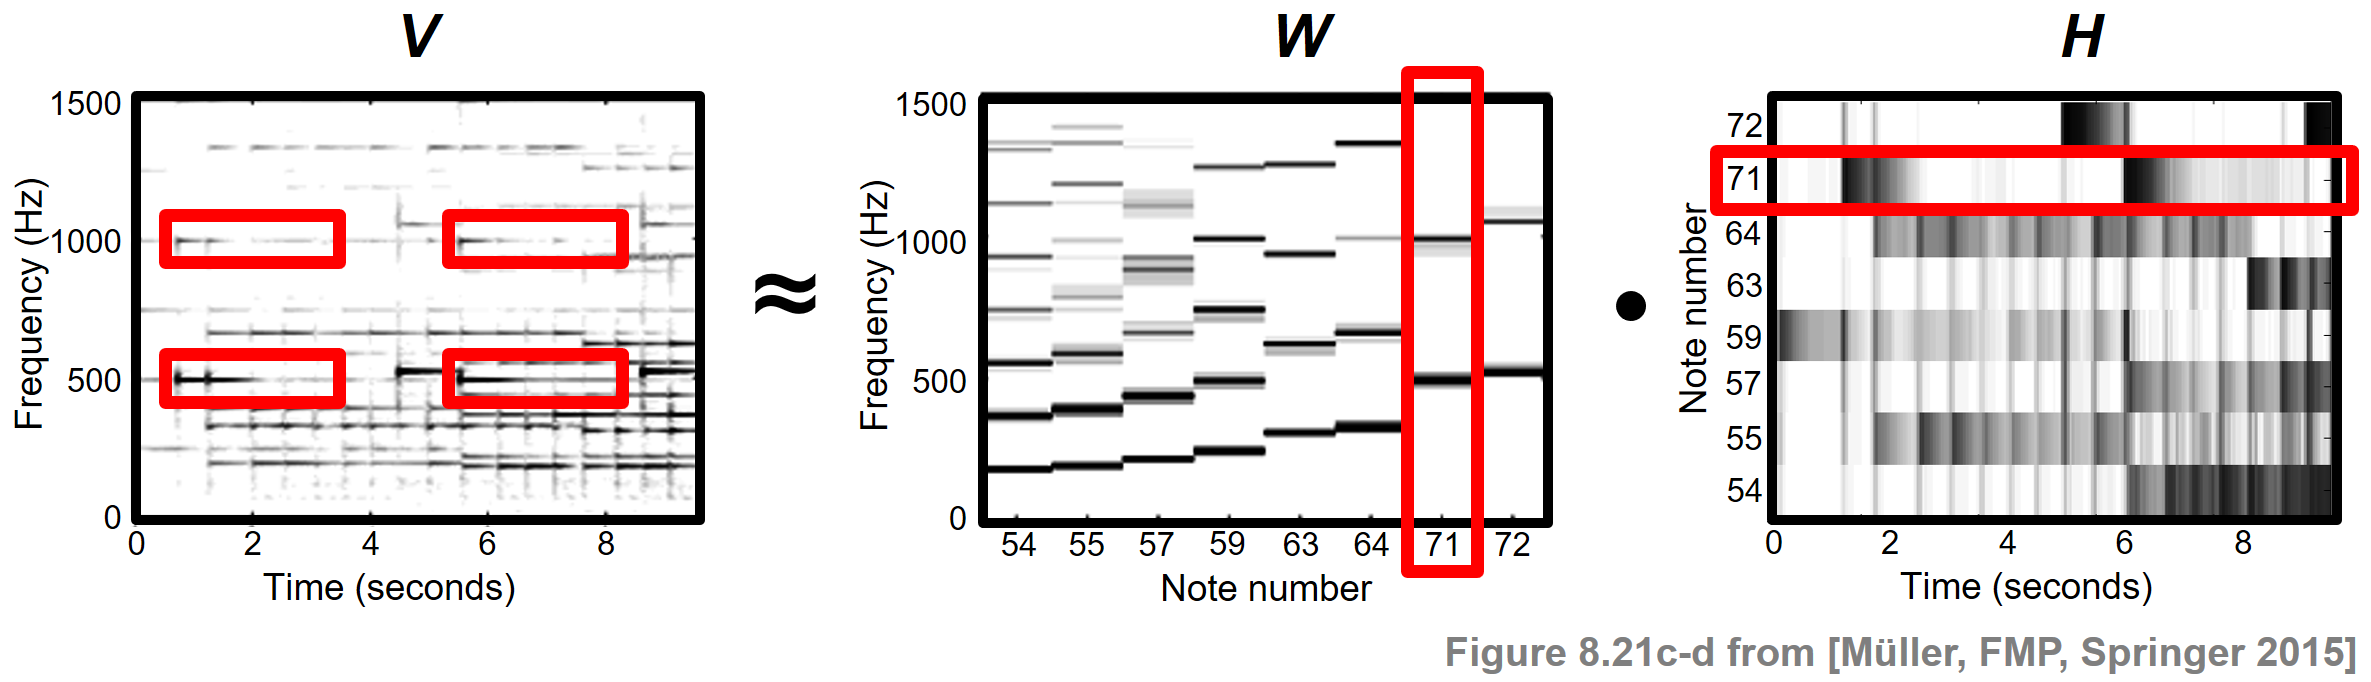

In [6]:
Image(path_img+"FMP_C8_F21c-e.png", width="700px")

- 이 경우 행렬 $W$로 지정된 각 템플릿은 특정 피치의 음이 $V$에서 스펙트럼적으로 구현되는 방식을 반영하고, 활성화 행렬 $H$는 악보의 피아노 롤 표현과 유사하게 보인다. 그러나 실제로는 어떤 신호 속성이 학습된 요인에 의해 궁극적으로 포착되는지 예측하기 어려운 경우가 많다.
- 이 분해를 더 잘 제어하기 위해 NMF가 음악적으로 의미 있는 분해를 생성하도록 제한하기 위해 추가 악보 정보를 사용할 수 있는 방법을 보기로 한다.

## Formal Definition of NMF

A matrix with real-valued coefficients is called **nonnegative** if all the coefficients are either zero or positive. Let $V \in \mathbb{R}_{\ge 0}^{K \times N}$ be such a nonnegative matrix having $K\in\mathbb{N}$ rows and $N\in\mathbb{N}$ columns. The dimensions $K$ and $N$ of the matrix $V$ are usually thought to be large. Given a number $R\in\mathbb{N}$ smaller than both $K$ and $N$, the goal of NMF is to find two nonnegative matrices $W \in \mathbb{R}_{\ge 0}^{K \times R}$ and $H \in \mathbb{R}_{\ge 0}^{R \times N}$ such that 

\begin{equation}
    V \approx W \cdot H.
\end{equation}

As said above, the columns of $V$ are regarded as $K$-dimensional data vectors, where $N$ is the number of data vectors. This matrix is then approximately factorized into a $(K \times R)$ matrix $W$ and an $(R \times N)$ matrix $H$. The parameter $R$, which is referred to as the **rank** of the factorization, is usually chosen to be much smaller than $K$ and $N$. Therefore, the number of coefficients in $W$ and $H$ is typically much smaller than the total number in $V$ (i.e., $KR+RN \ll KN$), and the product $WH$ can be thought of as a compressed version of the original matrix $V$. As already mentioned before, the column vectors of $W$ are also referred to as **template vectors**, whereas the weights specified by $H$ are called **activations**. As opposed to arbitrary linear combinations as known from linear algebra, the linear combinations occurring in the NMF context only involve nonnegative weights of nonnegative template vectors. As a result, there are no effects such as destructive interferences, where a (positive) component can be canceled out by adding a kind of inverse (negative) component. Instead, the data vectors need to be explained in a purely constructive fashion only involving positive components.

To find an approximate factorization $V \approx W \cdot H$, we need to specify a distance function that quantifies the 
quality of the approximation. There are many ways for defining such a distance function, leading to different NMF variants. In the following, we only consider one of these variants, which is based on the **Euclidean distance**. Let $A,B\in\mathbb{R}^{K \times N}$ be two matrices with coefficients $A_{kn}$ and $B_{kn}$
for $k\in[1:K]$ and $n\in[1:N]$. Then, the square of the Euclidean distance between $A$ and $B$ is defined by

\begin{equation}
    \|A-B\|^2:= \sum_{k=1}^{K}\sum_{n=1}^{N}(A_{kn}-B_{kn})^2.
\end{equation}

Based on this distance measure, we can formalize our NMF problem as follows: Given a nonnegative matrix $V\in\mathbb{R}_{\ge 0}^{K \times N}$ and a rank parameter $R$, minimize

\begin{equation}
    \|V-WH\|^2
\end{equation}

with respect to $W \in \mathbb{R}_{\ge 0}^{K \times R}$  and $H \in \mathbb{R}_{\ge 0}^{R \times N}$. In other words, regarding $\|V-WH\|^2$ as a joint function of $W$ and $H$, the objective is to find a minimum under the nonnegativity constraint for $W$ and $H$. For general matrices, this is a hard computational problem due to several reasons. First, it is in general difficult to enforce hard constraints such as nonnegativity on the solution of an optimization problem. Second, the joint optimization over both matrices $W$ and $H$ leads to computational challenges. In fact, when regarding $\|V-WH\|^2$ as a function of $W$ only or $H$ only, one can show that the resulting functions satisfy a strong property referred to as **convexity**. This property, which implies that any local minimum must be a global minimum, makes it possible to apply powerful tools from the field of convex analysis.  However, $\|V-WH\|^2$ is **not convex** in both matrices together. Therefore, it is unrealistic to expect an algorithm that can solve this problem in the sense of finding a global minimum. However, there are many techniques from numerical optimization that can be applied to find local minima.